In [1]:
""" Make a nice visualization plot (ascent) for radiosonde data """
import xarray as xr
import netCDF4 as nc
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import ticker
import os,sys
import matplotlib.pylab as plt
from tqdm import tqdm
from multiprocessing import Pool
from functools import partial
import datetime 
from numpy import sqrt 

#matplotlib.use('Agg')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
file = '/raid60/scratch/federico/HARVESTED_JULY2020/era5_1/0-20000-0-89606_era5_1_harvested_era5.conv.??????.89606.txt.gz.nc' 
#file      = '/raid60/scratch/federico/HARVESTED_JULY2020/era5_1/0-20000-0-10962_era5_1_harvested_era5.conv.??????.10962.txt.gz.nc'
file = '/raid8/srvx1/federico/NoteBook/reduced_0-20000-0-10393_CEUAS_merged_v0.nc'

In [3]:
""" Loading the observations table """
################## observations_table, header_table , indices, recordtimestamps
ot     = xr.open_dataset (file, engine = 'h5netcdf'  , group = "observations_table", decode_times = True ).to_dataframe()
ot     = ot[["date_time" , "z_coordinate","z_coordinate_type", "observed_variable" , "observation_value" , "source_id" , "report_id" ] ]
era5fb = xr.open_dataset (file, engine = 'h5netcdf'  , group = "era5fb", decode_times = True ).to_dataframe()
era5fb = era5fb [     [ 'date@hdr', 'time@hdr' ,'varno@body' , 'vertco_reference_1@body',  'obsvalue@body',  'an_depar@body' , 'fg_depar@body' ]     ]

# renaming columns since they cause troubles in reading the DF
name_map = {}
for c in era5fb.columns:
    name_map[c] = c.replace('@','')
    
era5fb = era5fb.rename(columns= name_map)


rts    = xr.open_dataset (file, engine = 'h5netcdf' , decode_times = True )['recordtimestamp'] # found in [3831:3832] 
ri     = xr.open_dataset (file, engine = 'h5netcdf' , decode_times = True )['recordindex']

#print(rts[:100])

In [4]:
""" Pick a random date_time """
std_plevs    = [10, 20, 30, 50, 70, 100, 150, 200, 250, 300, 400, 500, 700, 850, 925, 1000]



    
    

In [17]:
def plot_profile(ot = '', datetime = '' , station= '' , era5fb = '' ):
    
    stripped_datetime = np.datetime_as_string(datetime, unit='m') # convert to readable string 

    def get_data(ot='', era5fb = ''):
        ot_red = ot.loc[ (ot['date_time'] == datetime ) & ( ot['z_coordinate_type'] ==1 )  ] # maybe useless 
        red    = ot_red 

        all_press = list(set(  ot['z_coordinate'][:] ) )
        all_press.sort()
          
        data = {'pressure':[], 'temperature':[] , 'dewpoint':[], 'uwind':[], 'vwind':[] , 'speed':[], 'direction':[] , 'reana':[] , 'fg':[] }

        for p in all_press:
            try:
                
                t  = red.loc [ (ot['observed_variable'] == 85 )  & ( ot['z_coordinate'] == p ) ].observation_value.values[0]
                s  = red.loc [ (ot['observed_variable'] == 107 ) & ( ot['z_coordinate'] == p ) ].observation_value.values[0]
                d  = red.loc [ (ot['observed_variable'] == 106 ) & ( ot['z_coordinate'] == p ) ].observation_value.values[0]
                u  = red.loc [ (ot['observed_variable'] == 104 ) & ( ot['z_coordinate'] == p ) ].observation_value.values[0]
                v  = red.loc [ (ot['observed_variable'] == 105 ) & ( ot['z_coordinate'] == p ) ].observation_value.values[0]
                dp = red.loc [ (ot['observed_variable'] == 36 )  & ( ot['z_coordinate'] == p ) ].observation_value.values[0]
                
                # since I have departures, I have to subtract the actual value 
                ra = era5fb.loc [ (era5fb['varnobody'] == 2 ) &  ( era5fb['vertco_reference_1body'] == p )].an_deparbody.values[0] 
                fg = era5fb.loc [ (era5fb['varnobody'] == 2 ) &  ( era5fb['vertco_reference_1body'] == p )].fg_deparbody.values[0]
    
                data['pressure']       .append(p/100.)
                data['temperature']    .append(t)
                data['uwind']          .append(u)
                data['vwind']          .append(v)
                data['speed']          .append(s)
                data['direction']      .append(d)
                data['dewpoint']       .append(dp)
                data['reana']          .append(ra)
                data['fg']             .append(fg)
                
                
            except:
                pass
            
        return data

    def plot(ot = '' , era5fb='',  datetime = '' , station = ''):
        
        
        data = get_data(ot=ot, era5fb = era5fb )
        
        temp       = data['temperature']
        dp           = data['dewpoint']
        pressure = data['pressure']
        uwind     = data['uwind']
        vwind     = data['vwind']
        speed     = data['speed']
        reana     = data['reana']
        fguess    = data['fg']
        
        ###### ax1
        fs = 18
        os.system('mkdir output')
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,10) , gridspec_kw={'width_ratios': [5, 1]} )        
        #fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,10)  )        

        fig.suptitle('Profile ' + stripped_datetime + ' at Station  ' + station , y = 0.94, fontsize = fs)

        ax1.tick_params(axis='both', which='major', labelsize=15)
        ax1.tick_params(axis='both', which='minor', labelsize=8)
        w = ax1.invert_yaxis() 
        
        ax1.set_ylabel( 'Pressure [hPa]'   , fontsize = fs )     
        ax1.set_xlabel( 'Temperature [K]' , fontsize = fs )        
        ax1.grid(ls =":" , color = "lightgray")

        ax1.plot(temp, pressure , label = 'Air Temperature'       , color = 'red'  )
        ax1.plot(dp  , pressure , label = 'Dew Point Temperature' , color = 'cyan' )
        ax1.plot(temp, pressure , label = 'ERA5 Reanalysis'       , color = 'orange'  )
        ax1.plot(temp, pressure , label = 'First Guess    '       , color = 'yellow'  )

        
        #img = ax1.barbs(temp, pressure, uwind, vwind, length=6, pivot='middle' )        
        
        ax1.legend(loc = 'lower left', fontsize = fs)            


  
        ###### ax2
        plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,
        left = False, # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
        
        #ax2.tick_params(axis='both', which='major', labelsize=15)
        #ax2.tick_params(axis='both', which='minor', labelsize=8)
        w = ax2.invert_yaxis()
        
        cmap=plt.cm.jet      
        
        indices_std = [ pressure.index(p) for p in pressure if p in std_plevs ]
        X = [1 for p in range(len(indices_std))]
        uwind = [uwind[i]    for i in indices_std]
        vwind = [vwind[i]    for i in indices_std]
        Press = [pressure[i] for i in indices_std]
        C     = [speed[i] for i in indices_std] 
        
        print( X, uwind, vwind, Press) 
        img = ax2.barbs(X, Press, uwind, vwind, C, length=7, pivot='middle' , cmap= cmap  )  
        
        ax2.grid(ls =":" , color = "lightgray")
        ax2.set_xlabel( 'Wind Barbs' , fontsize = fs  )        
        #ax2.legend(loc = 'lower left', fontsize = fs-3)       
        ax2.axis('off')

        cbar = plt.colorbar(img, cmap= cmap , fraction= 1, pad=0.6 )
        cbar.set_label(label = 'Wind Speed [m/s]' , size=fs )
        cbar.ax.tick_params(labelsize=fs) 

        plt.savefig('output/pretty_profile.png' ,   bbox_inches = 'tight' , dpi = 250 )

        plt.show()
        #plt.close()
        plt.tight_layout()

        #plt.savefig('output/' + station + "_pretty_profile.png' ,   bbox_inches = 'tight' , dpi = 250 )

    dummy = plot(ot = ot, datetime = stripped_datetime , station= station , era5fb = era5fb )

In [18]:
""" Select a date_time to plot """
date = np.datetime64 (datetime.datetime(2014,12,10,6,0,28)  )
date = np.datetime64 (datetime.datetime(1990,1,1,0,0,0)  ) 



date = np.datetime64 (datetime.datetime(2019,12,25,5,0,53)  ) # Lindenberg 2019-12-25T05:00:53.000000000
 
        
index    = np.where ( rts == date )[0][0]
index_ot         = int( ri[index] )
index_ot_plus = int( ri[index+1] )



station = 'Lindenberg(Germany)' # Must be retrieved automatically from the station_configuration which is currently missing

red_ot     = ot[index_ot : index_ot_plus]
era5fb_red = era5fb[index_ot : index_ot_plus]

In [19]:
#print(era5fb_red[:100])


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] [47.65725, 26.046953, 21.096786, 6.798962, 18.133945, 21.82064, 16.874746, 9.184308, 10.037638, 13.219686, 1.9984698, 6.86075, 13.25527, 7.5023103, 6.8771176] [-19.25478, -13.849411, -0.36824578, -4.7606845, -7.6974034, -6.256968, -6.81784, -6.9208727, -8.725585, -4.2953362, 2.7506578, -3.4957268, -5.6265283, -7.76887, -7.1214643] [10.0, 20.0, 30.0, 50.0, 70.0, 100.0, 150.0, 200.0, 250.0, 300.0, 400.0, 500.0, 700.0, 850.0, 925.0]


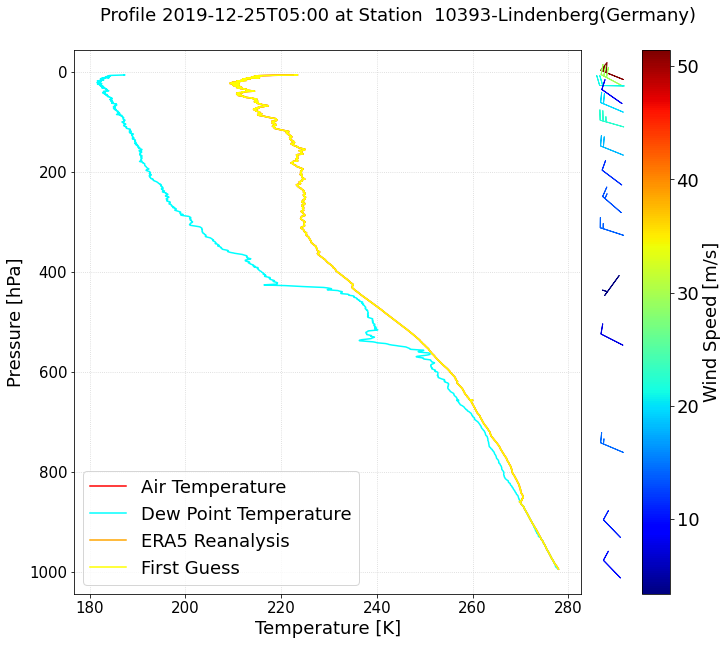

<Figure size 432x288 with 0 Axes>

In [20]:
dummy = plot_profile(ot = red_ot, datetime = date , station = '10393-Lindenberg(Germany)' , era5fb = era5fb_red)

In [16]:
print(0)

0
